# Rolling Up Data Drill # 

This is testing my Python data handling skills, with the data taken from the website here: https://mavenanalytics.io/data-drills/rolling-up-looking-back 

The task is aggregate total sales by month and store, calculate month-on-month changes at each store. The test is to accurately calculate the difference in sales (dollar amount) from April to May in the Astoria location.

I will be going beyond this to analyse the data further to see if there are any trends to pick up on.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("coffee_shop_sales.csv")
df.head()

,order_id,date,store,product,quantity,sales
0,1,1/01/2023,Lower Manhattan,Gourmet brewed coffee,2,6.0
1,2,1/01/2023,Lower Manhattan,Brewed Chai tea,2,6.2
2,3,1/01/2023,Lower Manhattan,Hot chocolate,2,9.0
3,4,1/01/2023,Lower Manhattan,Drip coffee,1,2.0
4,5,1/01/2023,Lower Manhattan,Brewed Chai tea,2,6.2


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149116 entries, 0 to 149115
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   order_id  149116 non-null  int64  
 1   date      149116 non-null  object 
 2   store     149116 non-null  object 
 3   product   149116 non-null  object 
 4   quantity  149116 non-null  int64  
 5   sales     149116 non-null  float64
dtypes: float64(1), int64(2), object(3)
memory usage: 6.8+ MB


The dataset is clean, and almost all the data types are correct. We need the date to not be an object, so the first step is to change that data type.

In [4]:
df["date"] = pd.to_datetime(df["date"], format="%d/%m/%Y")

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149116 entries, 0 to 149115
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   order_id  149116 non-null  int64         
 1   date      149116 non-null  datetime64[ns]
 2   store     149116 non-null  object        
 3   product   149116 non-null  object        
 4   quantity  149116 non-null  int64         
 5   sales     149116 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 6.8+ MB


That's sorted, so next step is to group the purchases by month and store, and calculate the stores total sales in that month. It first requires us to extract the month from the date.

In [5]:
# Extract month from the date
df["month"] = df["date"].dt.to_period("M")

# Group data by the month and store, then sum each group in a new dataframe
monthly_sales = df.groupby(["month", "store"])["sales"].sum().reset_index()

monthly_sales.head()

,month,store,sales
0,2023-01,Astoria,27313.66
1,2023-01,Hell's Kitchen,27820.65
2,2023-01,Lower Manhattan,26543.43
3,2023-02,Astoria,25105.34
4,2023-02,Hell's Kitchen,25719.80


In [6]:
monthly_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18 entries, 0 to 17
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype    
---  ------  --------------  -----    
 0   month   18 non-null     period[M]
 1   store   18 non-null     object   
 2   sales   18 non-null     float64  
dtypes: float64(1), object(1), period[M](1)
memory usage: 564.0+ bytes


Now we have each values for each stores monthly sales. Let's answer the question asked of us prior to exploring this data further - what is the difference in month to month sales in Astoria between April and May.

In [7]:
# Filter for April and May Astoria sales
april_astoria = monthly_sales.loc[
    (monthly_sales["month"] == "2023-04") & (monthly_sales["store"] == "Astoria"),
    "sales",
].values[0]

may_astoria = monthly_sales.loc[
    (monthly_sales["month"] == "2023-05") & (monthly_sales["store"] == "Astoria"),
    "sales",
].values[0]

difference = (may_astoria - april_astoria).round()
print(difference)

12951.0


12951 is the correct answer! Now let's take a look at the rest of the data and see if there are common trends.

In [8]:
# Create a column in monthly_sales dataframe that has the monthly difference attached to each month.
# Sort by store and month to ensure proper order
monthly_sales = monthly_sales.sort_values(["store", "month"])

# Calculate month-to-month difference for each store
monthly_sales["mom_change"] = monthly_sales.groupby("store")["sales"].diff()

monthly_sales.head(18)

,month,store,sales,mom_change
0,2023-01,Astoria,27313.66,NaN
3,2023-02,Astoria,25105.34,-2208.32
6,2023-03,Astoria,32835.43,7730.09
9,2023-04,Astoria,39477.61,6642.18
12,2023-05,Astoria,52428.76,12951.15
15,2023-06,Astoria,55083.11,2654.35
1,2023-01,Hell's Kitchen,27820.65,NaN
4,2023-02,Hell's Kitchen,25719.80,-2100.85
7,2023-03,Hell's Kitchen,33110.57,7390.77
10,2023-04,Hell's Kitchen,40304.14,7193.57


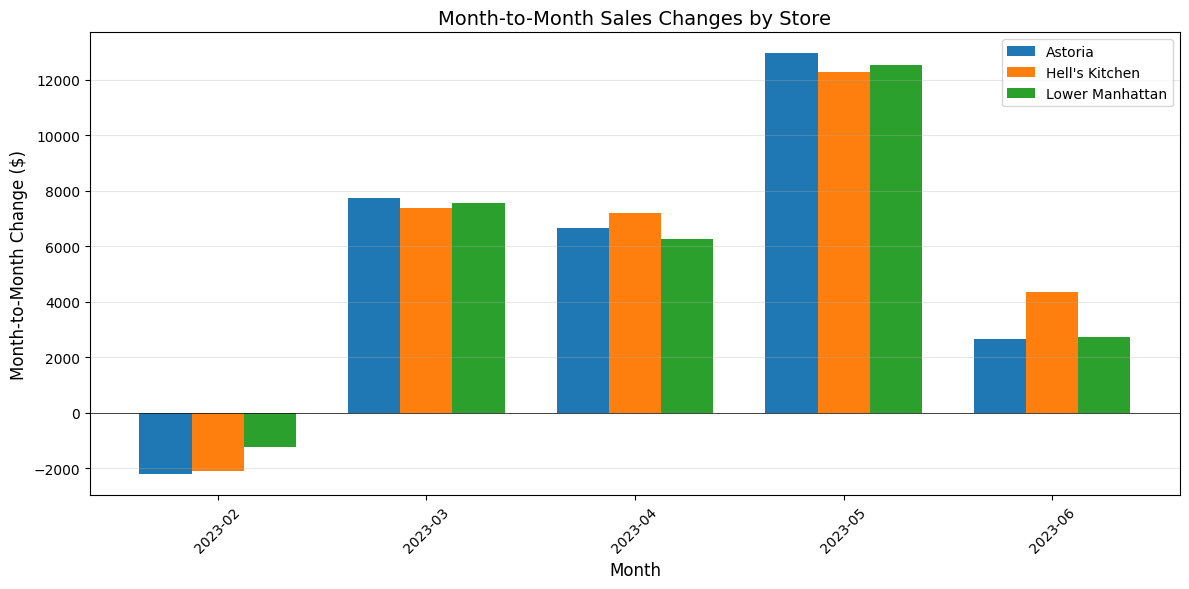

In [9]:
# Using matplotlib, create a graph of all the stores month to month changes, grouped by month

# Remove NaN values (first month has no previous month to compare)
plot_data = monthly_sales.dropna(subset=["mom_change"]).copy()

# Convert month to string for plotting
plot_data["month_str"] = plot_data["month"].astype(str)

# Create figure
fig, ax = plt.subplots(figsize=(12, 6))

# Get unique stores and months
stores = plot_data["store"].unique()
months = plot_data["month_str"].unique()

# Set width of bars and positions
bar_width = 0.25
x = range(len(months))

# Plot bars for each store
for i, store in enumerate(stores):
    store_data = plot_data[plot_data["store"] == store]
    positions = [pos + (i * bar_width) for pos in x]
    ax.bar(positions, store_data["mom_change"], bar_width, label=store)

# Customize the plot
ax.set_xlabel("Month", fontsize=12)
ax.set_ylabel("Month-to-Month Change ($)", fontsize=12)
ax.set_title("Month-to-Month Sales Changes by Store", fontsize=14)
ax.set_xticks([pos + bar_width for pos in x])
ax.set_xticklabels(months, rotation=45)
ax.legend()
ax.axhline(y=0, color="black", linestyle="-", linewidth=0.5)
ax.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()

This shows us that the growth rates (including January when it goes down) are pretty uniform across the stores. It may be useful to see what products are being sold, and how they are influenced month on month. This requires going back to our original dataframe and creating a products dataframe from there.

In [10]:
# Group data by month and product, aggregate both sales and quantity
product_sales = (
    df.groupby(["month", "product"])
    .agg({"sales": "sum", "quantity": "sum"})
    .reset_index()
)

# Rename columns for clarity
product_sales.rename(
    columns={"quantity": "qty_sold", "sales": "sales_amount"}, inplace=True
)

product_sales.head()

,month,product,sales_amount,qty_sold
0,2023-01,Barista Espresso,10461.20,2861
1,2023-01,Biscotti,2311.02,676
2,2023-01,Black tea,375.90,42
3,2023-01,Brewed Black tea,5535.50,2014
4,2023-01,Brewed Chai tea,8761.45,3011


In [11]:
product_sales["product"].unique()

array(['Barista Espresso', 'Biscotti', 'Black tea', 'Brewed Black tea',
       'Brewed Chai tea', 'Brewed Green tea', 'Brewed herbal tea',
       'Chai tea', 'Clothing', 'Drinking Chocolate', 'Drip coffee',
       'Espresso Beans', 'Gourmet Beans', 'Gourmet brewed coffee',
       'Green beans', 'Green tea', 'Herbal tea', 'Hot chocolate',
       'House blend Beans', 'Housewares', 'Organic Beans',
       'Organic Chocolate', 'Organic brewed coffee', 'Pastry',
       'Premium Beans', 'Premium brewed coffee', 'Regular syrup', 'Scone',
       'Sugar free syrup'], dtype=object)

In [12]:
import numpy as np

conditions = [
    product_sales["product"].str.contains("coffee|espresso", case=False),
    product_sales["product"].str.contains("tea", case=False),
    product_sales["product"].str.contains("chocolate", case=False),
    product_sales["product"].str.contains("scone|croissant|biscotti", case=False),
    product_sales["product"].str.contains("beans", case=False),
    product_sales["product"].str.contains("syrup|sauce", case=False),
]

categories = ["Coffee", "Tea", "Hot Chocolate", "Pastries", "Beans", "Condiments"]

product_sales["category"] = np.select(conditions, categories, default="Extras")

product_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 174 entries, 0 to 173
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype    
---  ------        --------------  -----    
 0   month         174 non-null    period[M]
 1   product       174 non-null    object   
 2   sales_amount  174 non-null    float64  
 3   qty_sold      174 non-null    int64    
 4   category      174 non-null    object   
dtypes: float64(1), int64(1), object(2), period[M](1)
memory usage: 6.9+ KB


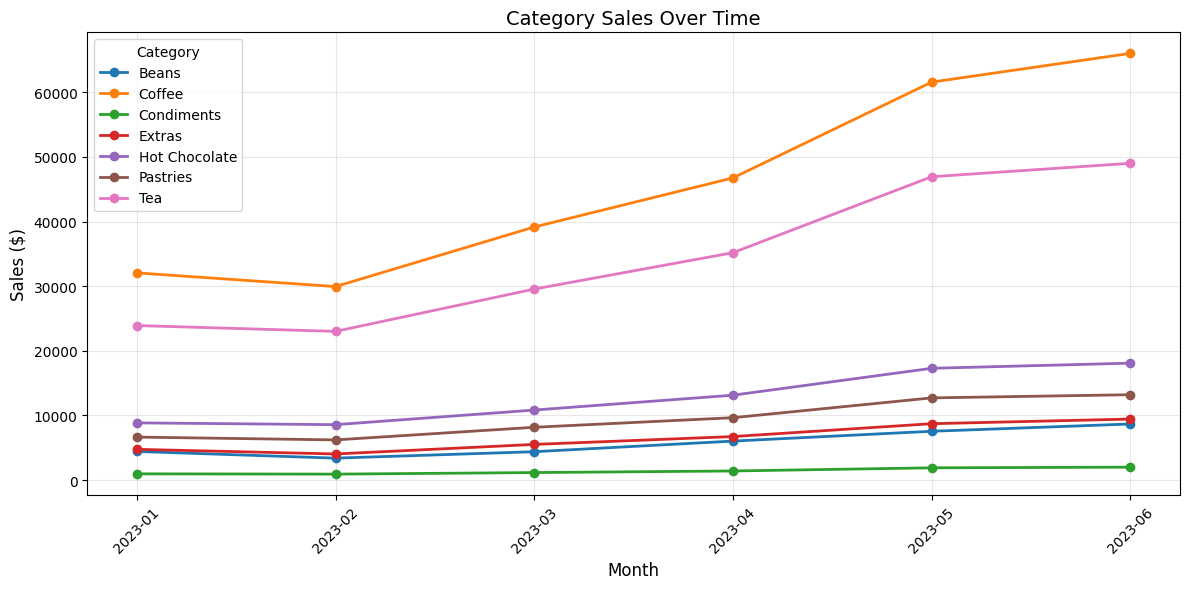

In [13]:
# Group by month and category
category_monthly = (
    product_sales.groupby(["month", "category"])["sales_amount"].sum().reset_index()
)

# Convert month to string for plotting
category_monthly["month_str"] = category_monthly["month"].astype(str)

# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Plot each category as a line
for category in category_monthly["category"].unique():
    category_data = category_monthly[category_monthly["category"] == category]
    ax.plot(
        category_data["month_str"],
        category_data["sales_amount"],
        marker="o",
        label=category,
        linewidth=2,
    )

# Customize the plot
ax.set_xlabel("Month", fontsize=12)
ax.set_ylabel("Sales ($)", fontsize=12)
ax.set_title("Category Sales Over Time", fontsize=14)
ax.legend(title="Category")
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

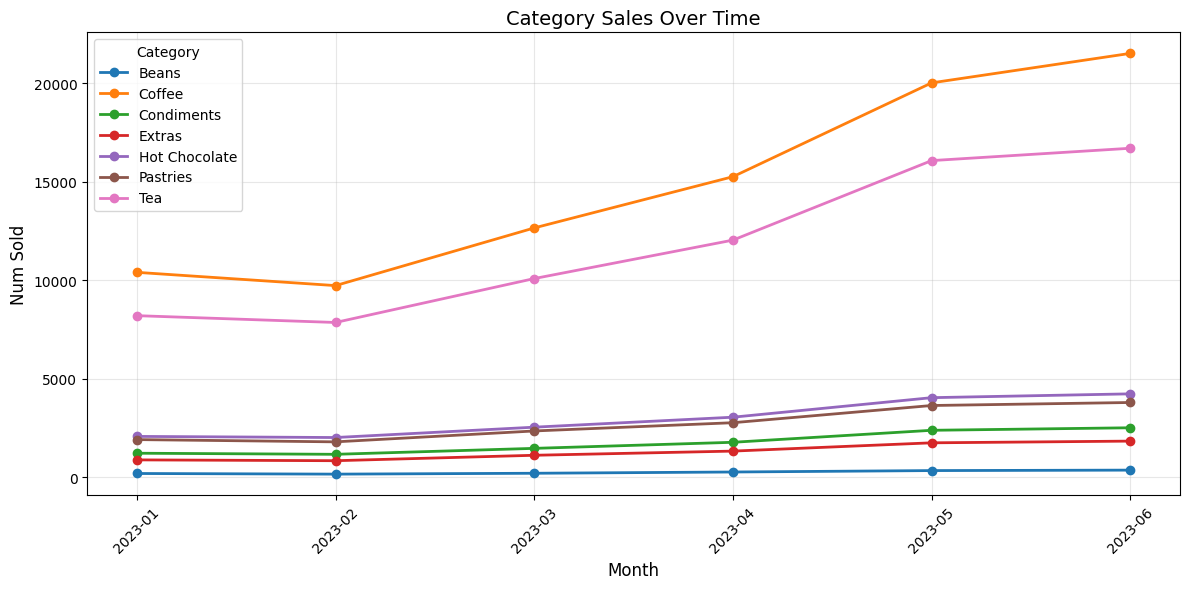

In [14]:
# Group by month and category
category_monthly = (
    product_sales.groupby(["month", "category"])["qty_sold"].sum().reset_index()
)

# Convert month to string for plotting
category_monthly["month_str"] = category_monthly["month"].astype(str)

# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Plot each category as a line
for category in category_monthly["category"].unique():
    category_data = category_monthly[category_monthly["category"] == category]
    ax.plot(
        category_data["month_str"],
        category_data["qty_sold"],
        marker="o",
        label=category,
        linewidth=2,
    )

# Customize the plot
ax.set_xlabel("Month", fontsize=12)
ax.set_ylabel("Num Sold", fontsize=12)
ax.set_title("Category Sales Over Time", fontsize=14)
ax.legend(title="Category")
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

From these two charts, we see that coffee and tea are quite clearly the top two items in both amount sold and money brought in. The ranking of the categories in each chart remains largely the same, except for the final 3 (condiments, extras and beans), which shuffle around a little bit, most likely to do with their price relative to each other. There are no signs of pricing anomalies (high number of purchases and low dollar price).

We should next see the revenue share of each category at each restaurant in a pie chart, seeing if some products are performing better at different stores.

In [15]:
df.head()

,order_id,date,store,product,quantity,sales,month
0,1,2023-01-01,Lower Manhattan,Gourmet brewed coffee,2,6.0,2023-01
1,2,2023-01-01,Lower Manhattan,Brewed Chai tea,2,6.2,2023-01
2,3,2023-01-01,Lower Manhattan,Hot chocolate,2,9.0,2023-01
3,4,2023-01-01,Lower Manhattan,Drip coffee,1,2.0,2023-01
4,5,2023-01-01,Lower Manhattan,Brewed Chai tea,2,6.2,2023-01


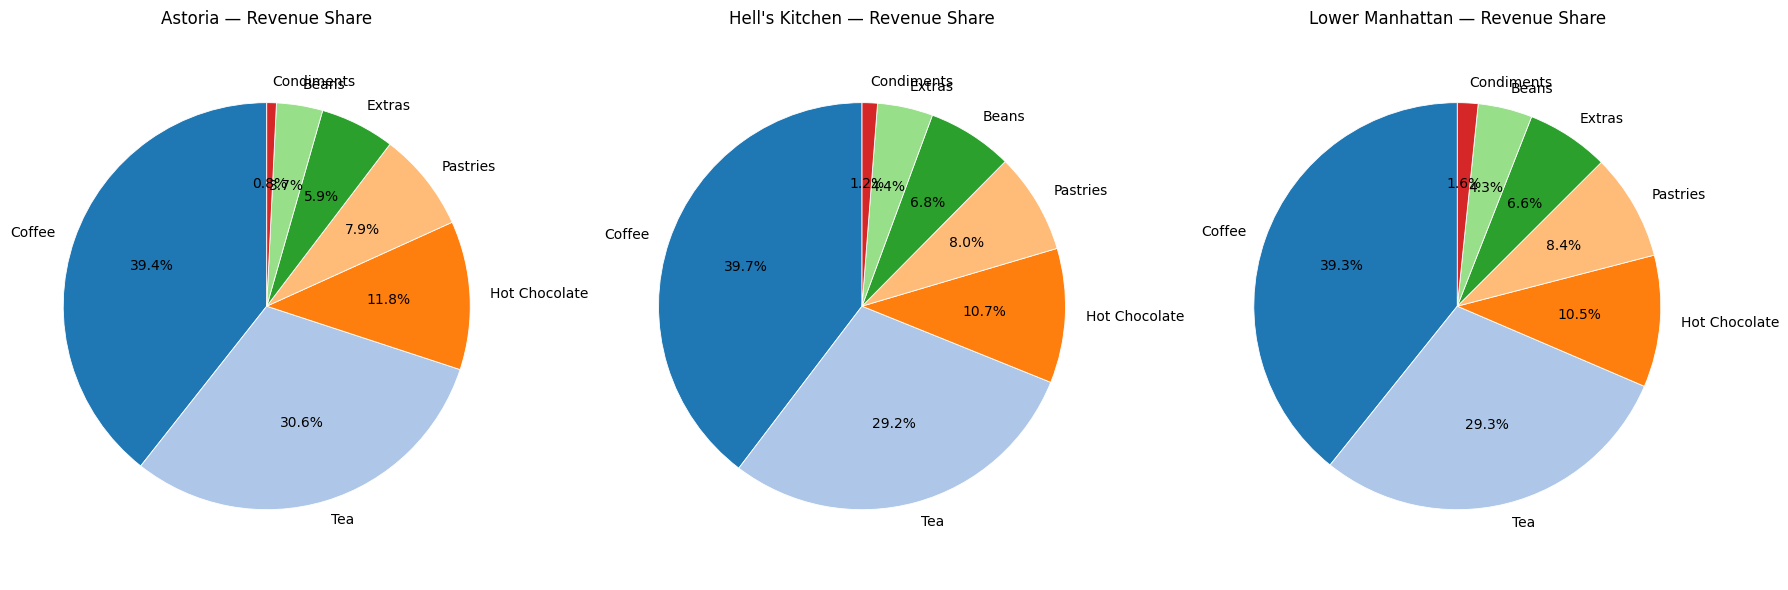

In [ ]:
# 1) Ensure categories exist on the raw dataframe (same logic used for product_sales)

conditions = [
    df["product"].str.contains("coffee|espresso", case=False, na=False),
    df["product"].str.contains("tea", case=False, na=False),
    df["product"].str.contains("chocolate", case=False, na=False),
    df["product"].str.contains(
        "scone|croissant|biscotti|muffin|cookie", case=False, na=False
    ),
    df["product"].str.contains("beans", case=False, na=False),
    df["product"].str.contains("syrup|sauce|cream", case=False, na=False),
]
categories = ["Coffee", "Tea", "Hot Chocolate", "Pastries", "Beans", "Condiments"]

df = df.copy()
df["category"] = np.select(conditions, categories, default="Extras")

# 2) Aggregate revenue by store and category
revenue_by_store = df.groupby(["store", "category"])["sales"].sum().reset_index()

# 3) Prepare stores list (take up to 3 stores side-by-side)
stores = revenue_by_store["store"].unique().tolist()
n_charts = min(3, len(stores))
if n_charts == 0:
    raise ValueError("No stores found in `revenue_by_store`.")

# 4) Build subplots and draw pie charts
fig, axes = plt.subplots(1, n_charts, figsize=(6 * n_charts, 6))
if n_charts == 1:
    axes = [axes]

cmap = plt.get_cmap("tab20")  # consistent color palette

for ax, store in zip(axes, stores[:n_charts]):
    data = revenue_by_store[revenue_by_store["store"] == store].set_index("category")[
        "sales"
    ]
    data = data[data > 0].sort_values(ascending=False)

    colors = [cmap(i) for i in range(len(data))]
    ax.pie(
        data.values,
        labels=data.index,
        autopct="%1.1f%%",
        startangle=90,
        colors=colors,
        wedgeprops={"edgecolor": "white", "linewidth": 0.6},
        textprops={"fontsize": 10},
    )
    ax.set_title(f"{store} — Revenue Share", fontsize=12)
    ax.axis("equal")

plt.tight_layout()
plt.show()

We can see that the revenue share for products across the store is nearly identical, with maximum and minimum values within categories across the stores varying very little. Coffee and Tea dominate, supplemented by Hot Chocolate and Pastries - to be expected for a cafe. If these businesses were looking to make some more money, the easiest place would be marginal increases to the prices of coffee and tea, as long as they weren't raised beyond the demand level.